In [1]:
import numpy as np
import pandas as pd
import re
import matplotlib.pylab as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras.preprocessing.text import Tokenizer
from keras import models
from keras import layers
from keras.utils import np_utils
from keras import regularizers
from math import ceil
import seaborn as sn

# Wartości stałe

In [2]:
NMB_words = 10000 #liczba slow w bibliotece
NMB_epoch = 20 #liczba pokolen
NMB_batch = 32 #wielkosc pobieranych probek
NMB_classes = 3 #liczba kategorii

# Funkcja stemmingowa

In [3]:
def stemmer_polish(text, black_list_file_location=''):
    blacklist = []
    if black_list_file_location:
        blacklist = get_blacklist(black_list_file_location)
    txt = text.split()
    for index, word in enumerate(txt):
        blacklisted = False
        if is_in_blacklist(word, blacklist):
            blacklisted = True
        stem = word
        stem = remove_nouns(stem)
        stem = remove_diminutive(stem)
        stem = remove_adjective_ends(stem)
        stem = remove_verbs_ends(stem)
        stem = remove_adverbs_ends(stem)
        stem = remove_plural_forms(stem)
        stem = remove_general_ends(stem)
        if blacklisted:
            stem = word
        txt[index] = stem
    return " ".join(txt)


def get_blacklist(location):
    blacklist_file = open(location, 'r')
    blacklist_list = []
    for line in blacklist_file:
        blacklist_list.append(line.decode('utf-8').strip(' \t\n\r'))
    return blacklist_list


def remove_general_ends(word):
    if len(word) > 4 and word[-2:] in {"ia", "ie"}:
        return word[:-2]
    if len(word) > 4 and word[-1:] in {"u", u"ą", "i", "a", u"ę", "y", u"ę", u"ł"}:
        return word[:-1]
    return word


def remove_diminutive(word):
    if len(word) > 6:
        if word[-5:] in {"eczek", "iczek", "iszek", "aszek", "uszek"}:
            return word[:-5]
        if word[-4:] in {"enek", "ejek", "erek"}:
            return word[:-2]
    if len(word) > 4:
        if word[-2:] in {"ek", "ak"}:
            return word[:-2]
    return word


def remove_verbs_ends(word):
    if len(word) > 5 and word.endswith("bym"):
        return word[:-3]
    if len(word) > 5 and word[-3:] in {"esz", "asz", "cie", u"eść", u"aść", u"łem", "amy", "emy"}:
        return word[:-3]
    if len(word) > 3 and word[-3:] in {"esz", "asz", u"eść", u"aść", u"eć", u"ać"}:
        return word[:-2]
    if len(word) > 3 and word[-3:] in {"aj"}:
        return word[:-1]
    if len(word) > 3 and word[-2:] in {u"ać", "em", "am", u"ał", u"ił", u"ić", u"ąc"}:
        return word[:-2]
    return word


def remove_nouns(word):
    if len(word) > 7 and word[-5:] in {"zacja", u"zacją", "zacji"}:
        return word[:-4]
    if len(word) > 6 and word[-4:] in {"acja", "acji", u"acją", "tach", "anie", "enie",
                                       "eniu", "aniu"}:
        return word[:-4]
    if len(word) > 6 and word.endswith("tyka"):
        return word[:-2]
    if len(word) > 5 and word[-3:] in {"ach", "ami", "nia", "niu", "cia", "ciu"}:
        return word[:-3]
    if len(word) > 5 and word[-3:] in {"cji", "cja", u"cją"}:
        return word[:-2]
    if len(word) > 5 and word[-2:] in {"ce", "ta"}:
        return word[:-2]
    return word


def remove_adjective_ends(word):
    if len(word) > 7 and word.startswith("naj") and (word.endswith("sze")
                                                     or word.endswith("szy")):
        return word[3:-3]
    if len(word) > 7 and word.startswith("naj") and word.endswith("szych"):
        return word[3:-5]
    if len(word) > 6 and word.endswith("czny"):
        return word[:-4]
    if len(word) > 5 and word[-3:] in {"owy", "owa", "owe", "ych", "ego"}:
        return word[:-3]
    if len(word) > 5 and word[-2:] in {"ej"}:
        return word[:-2]
    return word


def remove_adverbs_ends(word):
    if len(word) > 4 and word[:-3] in {"nie", "wie"}:
        return word[:-2]
    if len(word) > 4 and word.endswith("rze"):
        return word[:-2]
    return word


def remove_plural_forms(word):
    if len(word) > 4 and (word.endswith(u"ów") or word.endswith("om")):
        return word[:-2]
    if len(word) > 4 and word.endswith("ami"):
        return word[:-3]
    return word


def is_in_blacklist(word, blacklist):
    if word in blacklist:
        return True
    return False

# Funkcje dodatkowe

In [4]:
def preprocessor(text):
    text = re.sub('<[^>]*>', '', text)
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text)
    text = re.sub('[\W]+', ' ', text.lower()) + \
           ' '.join(emoticons).replace('-', '')
    return text


def build_model(model, X_tr, y_tr, X_vld, y_vld):
    print("Building model: " + model._name)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
    model_out = model.fit(X_tr, y_tr, epochs=NMB_epoch, batch_size=NMB_batch, validation_data=(X_vld, y_vld), verbose=0)
    return model_out


def model_param(model, model_out, parametr):
    global ind
    metric = model_out.history[parametr]
    val_metric = model_out.history['val_' + parametr]
    e = range(1, NMB_epoch + 1)
    plt.subplot(ceil(ind/2), 2, ind)
    plt.plot(e, metric, 'bo', label='Train ' + parametr)
    plt.plot(e, val_metric, 'b', label='Validation ' + parametr)
    plt.xlabel('Epoch number')
    plt.ylabel(parametr)
    plt.title('Comparing training and validation ' + parametr + ' for ' + model._name)
    plt.legend()
    if ind%2 == 0:
        plt.show()
    ind += 1


def model_testing(model, X_train, y_train, X_test, y_test, epoch_stop):
    model.fit(X_train, y_train, epochs=epoch_stop, batch_size=NMB_batch, verbose=0)
    score = model.evaluate(X_test, y_test)
    print(model._name)
    #print("Test Loss: %.2f%%" % (score[0] * 100))
    print("Test Accuracy: %.2f%%" % (score[1] * 100))
    return score


def clear_stopwords(input_text):
    stop_list = open('Dodatkowe_dane/polishstopwords.txt', 'r').read().split()
    wyjatki = ["nie"]
    words = input_text.split()
    clean_words = [word for word in words if (word not in stop_list or word in wyjatki) and len(word) > 1]
    return " ".join(clean_words)


def clear_mentions(input_text):
    return re.sub(r'@\w+', '', input_text)


def optimal_epoch(model_hist):
    min_epoch = np.argmin(model_hist.history['val_loss']) + 1
    print("Minimum validation loss reached in epoch {}".format(min_epoch))
    return min_epoch

# Podział i przygotowanie grup (trenowanie, walidacja, testowanie)

In [5]:
np.random.seed(7)

filename = 'Dane_dla_modeli/Tytuly_reczne_oznaczenie.csv'

dataset = pd.read_csv(filename, delimiter=",")

# Usuniecie pustych wartosci
dataset = dataset[dataset['description'].notnull() & dataset['rate'].notnull()]
dataset2 = dataset[dataset['description'].notnull() & dataset['rate'].notnull()]

# Usuniecie znakow specjalnych, stemming
dataset.description = dataset.description.apply(preprocessor) \
    .apply(clear_stopwords).apply(clear_mentions).apply(stemmer_polish)
dataset.apply(np.random.permutation, axis=1)

# Podzial na grupy
X = dataset['description']
y = dataset['rate']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Wielkosc poszczegolnych grup
print("X_train shape: " + str(X_train.shape))
print("X_test shape: " + str(X_test.shape))
print("y_train shape: " + str(y_train.shape))
print("y_test shape: " + str(y_test.shape))

#Zmiana zdan na wektory, tworzenie biblioteki slow
tk = Tokenizer(num_words=NMB_words, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{"}~\t\n', lower=True,
               char_level=False, split=' ')
tk.fit_on_texts(X_train)

X_train = tk.texts_to_matrix(X_train, mode='binary')
X_test = tk.texts_to_matrix(X_test, mode='binary')
X_val = tk.texts_to_matrix(X_val, mode='binary')

y_train = np_utils.to_categorical(y_train, NMB_classes)
y_test = np_utils.to_categorical(y_test, NMB_classes)
y_val = np_utils.to_categorical(y_val, NMB_classes)

X_train shape: (8099,)
X_test shape: (2532,)
y_train shape: (8099,)
y_test shape: (2532,)


# Wybór modelu

In [6]:
# Base model
base_model = models.Sequential()
base_model.add(layers.Dense(64, activation='relu', input_shape=(NMB_words,)))
base_model.add(layers.Dense(64, activation='relu'))
base_model.add(layers.Dense(NMB_classes, activation='softmax'))
base_model._name = "Base_model"

base_history = build_model(base_model, X_train, y_train, X_val, y_val)
base_min = optimal_epoch(base_history)

# Reduce model usuwany warstwy
red_model = models.Sequential()
red_model.add(layers.Dense(16, activation='relu', input_shape=(NMB_words,)))
red_model.add(layers.Dense(NMB_classes, activation='softmax'))
red_model._name = "Reduce_model"

red_history = build_model(red_model, X_train, y_train, X_val, y_val)
red_min = optimal_epoch(red_history)

# Regularization model karze sieć w procesie trenowania
rg_model = models.Sequential()
rg_model.add(layers.Dense(64, kernel_regularizer=regularizers.l2(0.001), activation='relu',
                            input_shape=(NMB_words,)))
rg_model.add(layers.Dense(64, kernel_regularizer=regularizers.l2(0.001), activation='relu'))
rg_model.add(layers.Dense(NMB_classes, activation='softmax'))
rg_model._name = "Regularization_model"

rg_history = build_model(rg_model, X_train, y_train, X_val, y_val)
rg_min = optimal_epoch(rg_history)

# Drop model w wektorze pojawiają się 0 w losowych miejscach
dp_model = models.Sequential()
dp_model.add(layers.Dense(64, activation='relu', input_shape=(NMB_words,)))
dp_model.add(layers.Dropout(0.5))
dp_model.add(layers.Dense(64, activation='relu'))
dp_model.add(layers.Dropout(0.5))
dp_model.add(layers.Dense(NMB_classes, activation='softmax'))
dp_model._name = "Drop_model"

dp_history = build_model(dp_model, X_train, y_train, X_val, y_val)
dp_min = optimal_epoch(dp_history)

Building model: Base_model
Minimum validation loss reached in epoch 1
Building model: Reduce_model
Minimum validation loss reached in epoch 4
Building model: Regularization_model
Minimum validation loss reached in epoch 2
Building model: Drop_model
Minimum validation loss reached in epoch 2


# Wyniki trenowania - testowanie

In [8]:
base_results = model_testing(base_model, X_train, y_train, X_test, y_test, base_min)
red_results = model_testing(red_model, X_train, y_train, X_test, y_test, red_min)
rg_results = model_testing(rg_model, X_train, y_train, X_test, y_test, rg_min)
dp_results = model_testing(dp_model, X_train, y_train, X_test, y_test, dp_min)

# Zapisanie modelu
# base_model.save('Modele/base_modelBankier.h5')
# red_model.save('Modele/red_modelBankier.h5')
# rg_model.save('Modele/rg_modelBankier.h5')
# dp_model.save('Modele/dp_modelBankier.h5')

80/80 [==============================] - 0s 1ms/step - loss: 0.9184 - acc: 0.8302
Base_model
Test Accuracy: 83.02%
80/80 [==============================] - 0s 1ms/step - loss: 0.7042 - acc: 0.8377
Reduce_model
Test Accuracy: 83.77%
80/80 [==============================] - 0s 2ms/step - loss: 0.5834 - acc: 0.8602
Regularization_model
Test Accuracy: 86.02%
80/80 [==============================] - 0s 1ms/step - loss: 0.8307 - acc: 0.8543
Drop_model
Test Accuracy: 85.43%


# Wyniki uczenia oraz macierz błędu

## Model bazowy

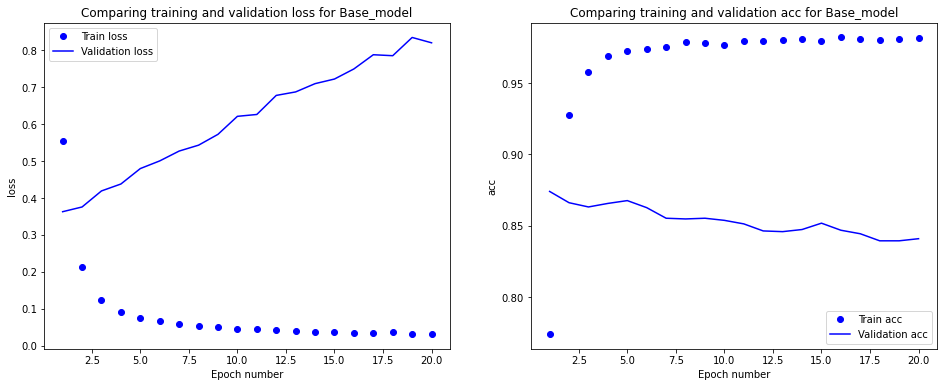

<AxesSubplot:title={'center':'Base_model'}>

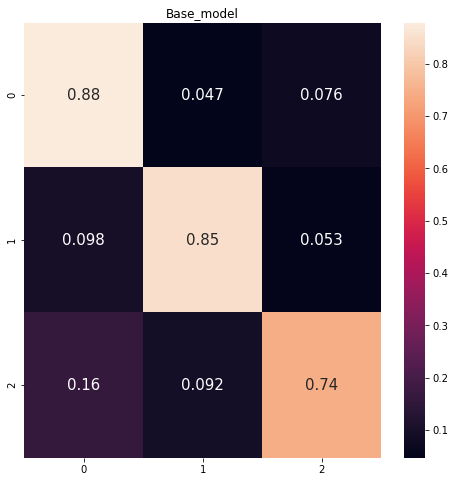

In [7]:
ind = 1
plt.figure(figsize = (16,6))

model_param(base_model, base_history, 'loss')
model_param(base_model, base_history, 'acc')

predictions = base_model.predict(X_test)

matrix = confusion_matrix(y_test.argmax(axis=1), np.around(predictions, decimals=0).argmax(axis=1))
conf_matrix = pd.DataFrame(matrix, index = ['Neutralne','Negatywne','Pozytywne'],columns = ['Neutralne','Negatywne','Pozytywne'])
conf_matrix = conf_matrix.to_numpy()
conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis] # normalizing
plt.figure(figsize = (8,8))
plt.title(base_model._name)
sn.heatmap(conf_matrix, annot=True, annot_kws={"size": 15})

## Model redukcyjny

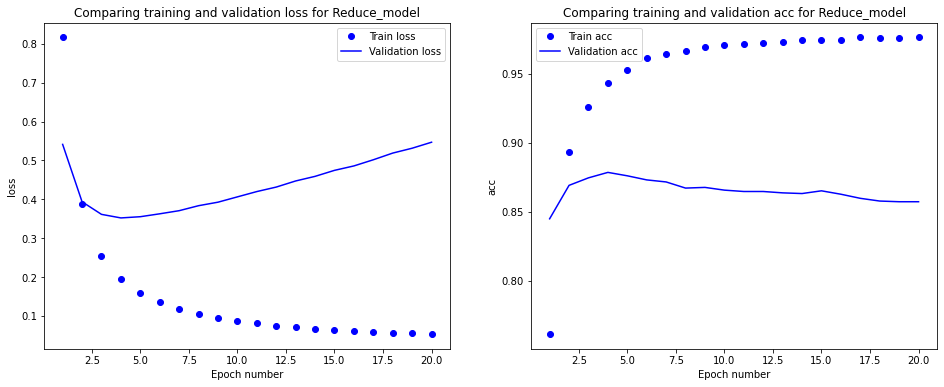

<AxesSubplot:title={'center':'Reduce_model'}>

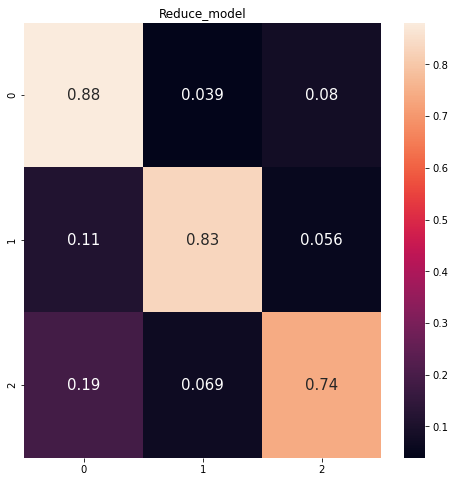

In [10]:
ind = 1
plt.figure(figsize = (16,6))

model_param(red_model, red_history, 'loss')
model_param(red_model, red_history, 'acc')

predictions = red_model.predict(X_test)

matrix = confusion_matrix(y_test.argmax(axis=1), np.around(predictions, decimals=0).argmax(axis=1))
conf_matrix = pd.DataFrame(matrix, index = ['Neutralne','Negatywne','Pozytywne'],columns = ['Neutralne','Negatywne','Pozytywne'])
conf_matrix = conf_matrix.to_numpy()
conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis] # normalizing
plt.figure(figsize = (8,8))
plt.title(red_model._name)
sn.heatmap(conf_matrix, annot=True, annot_kws={"size": 15})

## Model regularyzowany

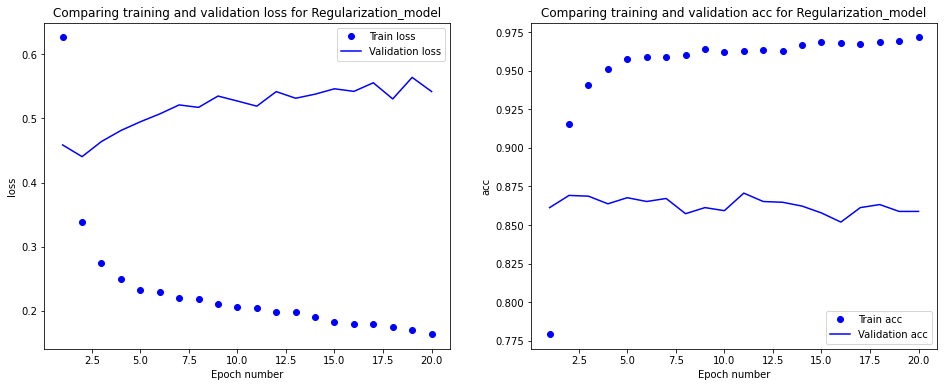

<AxesSubplot:title={'center':'Regularization_model'}>

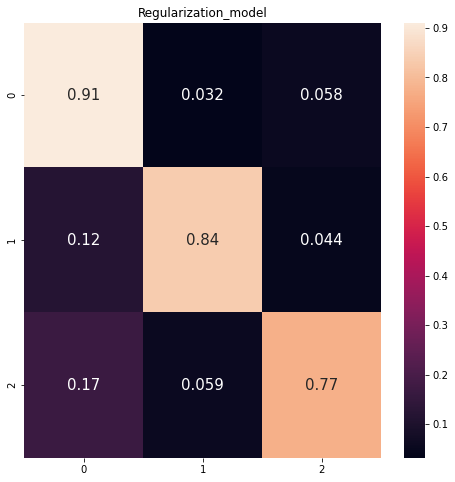

In [9]:
ind = 1
plt.figure(figsize = (16,6))

model_param(rg_model, rg_history, 'loss')
model_param(rg_model, rg_history, 'acc')

predictions = rg_model.predict(X_test)

matrix = confusion_matrix(y_test.argmax(axis=1), np.around(predictions, decimals=0).argmax(axis=1))
conf_matrix = pd.DataFrame(matrix, index = ['Neutralne','Negatywne','Pozytywne'],columns = ['Neutralne','Negatywne','Pozytywne'])
conf_matrix = conf_matrix.to_numpy()
conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis] # normalizing
plt.figure(figsize = (8,8))
plt.title(rg_model._name)
sn.heatmap(conf_matrix, annot=True, annot_kws={"size": 15})

## Model z metodą porzucania

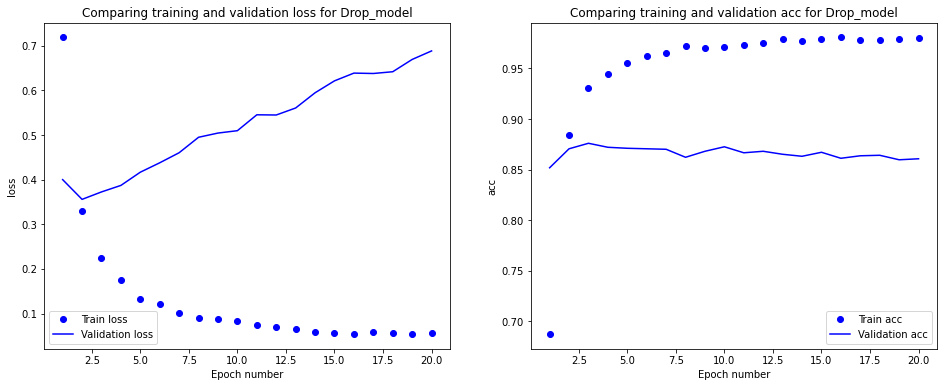

<AxesSubplot:title={'center':'Drop_model'}>

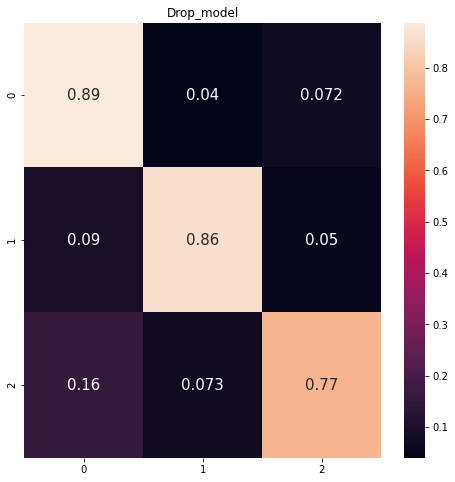

In [12]:
ind = 1
plt.figure(figsize = (16,6))

model_param(dp_model, dp_history, 'loss')
model_param(dp_model, dp_history, 'acc')

predictions = dp_model.predict(X_test)

matrix = confusion_matrix(y_test.argmax(axis=1), np.around(predictions, decimals=0).argmax(axis=1))
conf_matrix = pd.DataFrame(matrix, index = ['Neutralne','Negatywne','Pozytywne'],columns = ['Neutralne','Negatywne','Pozytywne'])
conf_matrix = conf_matrix.to_numpy()
conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis] 
plt.figure(figsize = (8,8))
plt.title(dp_model._name)
sn.heatmap(conf_matrix, annot=True, annot_kws={"size": 15})

# Prognoza pojedynczych danych

In [8]:
zdanie = 'Wskażniki na łeb i szyję lecą'
zdanie = stemmer_polish(clear_mentions(clear_stopwords(preprocessor(zdanie))))
sequence = tk.texts_to_matrix([zdanie], mode='binary')
sentiment = ['Neutralny','Negatywny','Pozytywny']

print(base_model._name + ' - ' + sentiment[np.around(base_model.predict(sequence), decimals=0).argmax(axis=1)[0]])
print(red_model._name + ' - ' + sentiment[np.around(red_model.predict(sequence), decimals=0).argmax(axis=1)[0]])
print(rg_model._name + ' - ' + sentiment[np.around(rg_model.predict(sequence), decimals=0).argmax(axis=1)[0]])
print(dp_model._name + ' - ' + sentiment[np.around(dp_model.predict(sequence), decimals=0).argmax(axis=1)[0]])

Base_model - Negatywny
Reduce_model - Negatywny
Regularization_model - Neutralny
Drop_model - Negatywny


# Prognoza grupy danych

In [38]:
filename2 = 'Dane_dla_modeli\Dane_do_predykcji.csv'
predykcja = pd.read_csv(filename2,encoding='utf-8-sig',delimiter=",")

In [39]:
predykcja

,index,Tytul,Autor,Komentarze,Data,Spolka,clean_data
0,1,Kiedy ruszy sprzdaz testow na Covid firmy Genomtec?,~Pytanie,4,2021-03-27 14:50:00,GENOMTEC,ruszy sprzdaz testow covid firmy genomtec
1,2,Nie dotykać i omijać na razie te akcje,~Karol,2,2021-03-27 13:43:00,GENOMTEC,dotykać omijać razie akcje
2,3,Kwarantanna na akcje,~Jakotako,3,2021-03-27 11:06:00,GENOMTEC,kwarantanna akcje
3,4,Knf,~Paweł,7,2021-03-27 07:54:00,GENOMTEC,knf
4,5,WAŻNE!!! Proszę korzystać z funkcji „zgłoś do moderatora”,~Admin,5,2021-03-27 07:35:00,GENOMTEC,ważne proszę korzystać funkcji zgłoś moderatora
...,...,...,...,...,...,...,...
53188,1,Wycena Gamivo,~Honestly,4,2021-04-23 09:48:00,GAMIVO,wycena gamivo
53189,2,co muslicie o powstaniu polskiej superligi -to moze sie udac pokolenie z,~jedrek,1,2021-04-22 18:03:00,GAMIVO,muslicie powstaniu polskiej superligi moze udac pokolenie
53190,3,"Rękę w górę kto zarobiony, brał ktos na lewar?",~Wydmucha,3,2021-04-22 12:24:00,GAMIVO,rękę górę zarobiony brał ktos lewar
53191,4,"Dzisiaj debiut Gamivo, spółki wycenianej 100% wyżej niż debiut",~Gamivo,3,2021-04-22 11:12:00,GAMIVO,debiut gamivo spółki wycenianej wyżej debiut


In [40]:
predykcja.Tytul = predykcja.Tytul.apply(preprocessor) \
    .apply(clear_stopwords).apply(clear_mentions).apply(stemmer_polish)
data_to_list = predykcja['Tytul'].values.tolist()
predykcja["sentyment"] = np.nan

In [41]:
for i in range(len(data_to_list)):
    sequence = tk.texts_to_matrix([data_to_list[i]], mode='binary')
    predykcja["sentyment"][i] = sentiment[np.around(rg_model.predict(sequence), decimals=0).argmax(axis=1)[0]]
    if (i % 461 == 0):
        percentage = i/len(data_to_list) * 100
        formatted_percentage = "{:.0f}".format(percentage)
        print(formatted_percentage,"%")

<ipython-input-41-c90789f23e08>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predykcja["sentyment"][i] = sentiment[np.around(rg_model.predict(sequence), decimals=0).argmax(axis=1)[0]]
C:\Users\august\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


0 %
1 %
2 %
3 %
3 %
4 %
5 %
6 %
7 %
8 %
9 %
10 %
10 %
11 %
12 %
13 %
14 %
15 %
16 %
16 %
17 %
18 %
19 %
20 %
21 %
22 %
23 %
23 %
24 %
25 %
26 %
27 %
28 %
29 %
29 %
30 %
31 %
32 %
33 %
34 %
35 %
36 %
36 %
37 %
38 %
39 %
40 %
41 %
42 %
42 %
43 %
44 %
45 %
46 %
47 %
48 %
49 %
49 %
50 %
51 %
52 %
53 %
54 %
55 %
55 %
56 %
57 %
58 %
59 %
60 %
61 %
62 %
62 %
63 %
64 %
65 %
66 %
67 %
68 %
68 %
69 %
70 %
71 %
72 %
73 %
74 %
75 %
75 %
76 %
77 %
78 %
79 %
80 %
81 %
81 %
82 %
83 %
84 %
85 %
86 %
87 %
88 %
88 %
89 %
90 %
91 %
92 %
93 %
94 %
94 %
95 %
96 %
97 %
98 %
99 %
100 %


In [42]:
pd.set_option('display.max_colwidth', None)
predykcja[["Tytul", "sentyment"]].head(20)

,Tytul,sentyment
0,rusz sprzdaz testow covid firm genomtec,Neutralny
1,nie dotyk omij raz akcje,Neutralny
2,kwarantann akcje,Neutralny
3,knf,Negatywny
4,ważne prosz korzyst funkc zgłoś moderator,Negatywny
5,ogladalis gambit krolow,Neutralny
6,leszcze kiszonk,Negatywny
7,pyta info czek miało dalej spad,Neutralny
8,ciekawe,Neutralny
9,same tekst czyt serinius,Pozytywny


In [43]:
sentyment = pd.DataFrame(predykcja.groupby(predykcja['sentyment'])['Tytul'].count()).reset_index().sort_values(by=['sentyment'], ascending=False)
autor_df = sentyment.rename(columns={'sentyment': 'Sentyment', 'Tytul': 'Liczba postow'})

# Liczba postów względem sentymentów

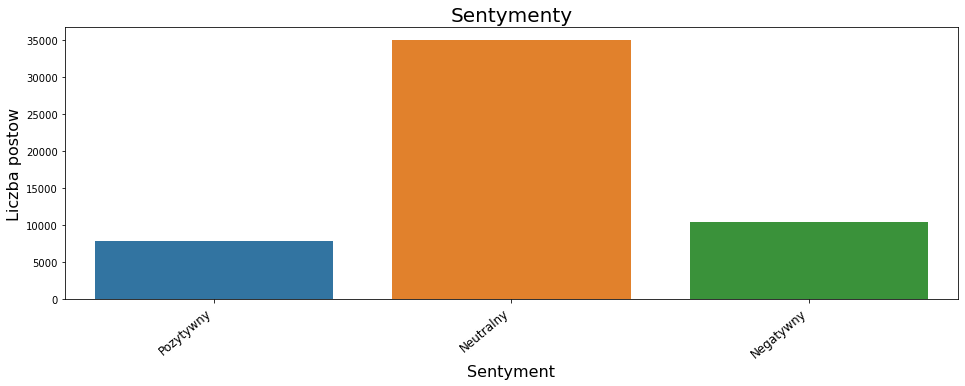

In [44]:
plt.figure(figsize=(16,5))
ax = sn.barplot(data=autor_df, x= "Sentyment", y = "Liczba postow")
ax.set_ylabel('Liczba postow', fontsize=16)
ax.set_xlabel('Sentyment', fontsize=16)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right", fontsize=12)
ax.set_title("Sentymenty", fontsize=20)
plt.show()

In [53]:
#Spółka z najbardziej negatywnym sentymentem
negatywny_df = predykcja[predykcja['sentyment'] == 'Negatywny']
negatywny = pd.DataFrame(negatywny_df.groupby(negatywny_df['Spolka'])['sentyment'].count()).reset_index().sort_values(by=['sentyment'], ascending=False)
negatywny = negatywny.head(30)

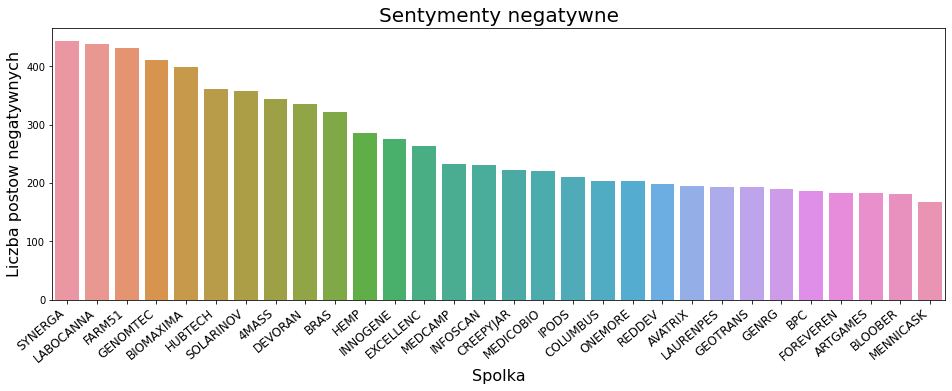

In [60]:
plt.figure(figsize=(16,5))
ax = sn.barplot(data=negatywny, x= "Spolka", y = "sentyment")
ax.set_ylabel('Liczba postow negatywnych', fontsize=16)
ax.set_xlabel('Spolka', fontsize=16)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right", fontsize=12)
ax.set_title("Sentymenty negatywne", fontsize=20)
plt.show()

In [106]:
#Spółka z najbardziej pozytywnym sentymentem
pozytywny_df = predykcja[predykcja['sentyment'] == 'Pozytywny']
pozytywny = pd.DataFrame(pozytywny_df.groupby(pozytywny_df['Spolka'])['sentyment'].count()).reset_index().sort_values(by=['sentyment'], ascending=False)
pozytywny = pozytywny.head(30)

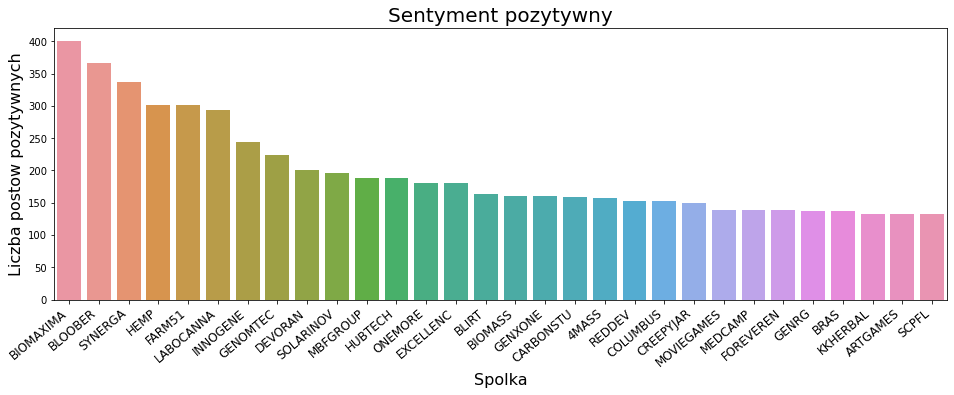

In [107]:
plt.figure(figsize=(16,5))
ax = sn.barplot(data=pozytywny, x= "Spolka", y = "sentyment")
ax.set_ylabel('Liczba postow pozytywnych', fontsize=16)
ax.set_xlabel('Spolka', fontsize=16)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right", fontsize=12)
ax.set_title("Sentyment pozytywny", fontsize=20)
plt.show()

In [68]:
predykcja.to_csv (r'predykcja_final.csv', index = False, header=True)

In [108]:
#Spółka z najbardziej pozytywnym sentymentem
pozytywny_df2 = predykcja[predykcja['Spolka'] == 'SYNERGA']
pozytywny_df3 = pozytywny_df2[pozytywny_df2['Autor'] == '~Szeryf']
pozytywny2 = pd.DataFrame(pozytywny_df3.groupby(pozytywny_df3['sentyment'])['Autor'].count()).reset_index().sort_values(by=['Autor'], ascending=False)
pozytywny2 = pozytywny2.head(30)

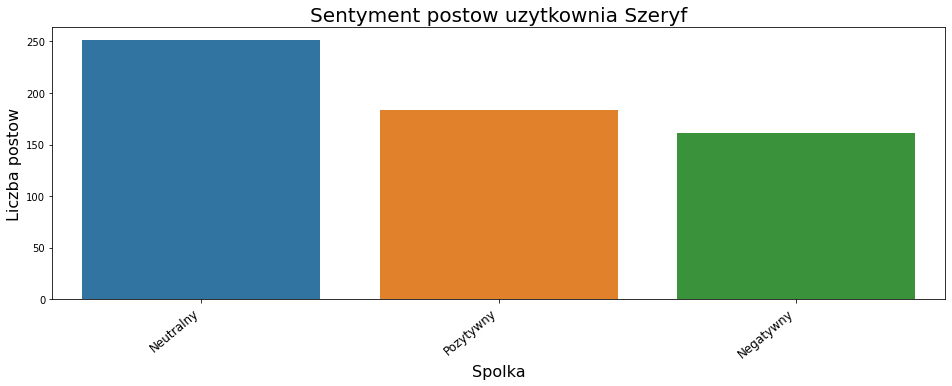

In [109]:
plt.figure(figsize=(16,5))
ax = sn.barplot(data=pozytywny2, x= "sentyment", y = "Autor")
ax.set_ylabel('Liczba postow', fontsize=16)
ax.set_xlabel('Spolka', fontsize=16)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right", fontsize=12)
ax.set_title("Sentyment postow uzytkownia Szeryf", fontsize=20)
plt.show()